In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from PIL import Image

In [2]:
df = pd.read_csv('df.csv', index_col=0)

In [3]:
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [4]:
import autoencoder

import importlib
importlib.reload(autoencoder)

from autoencoder import Autoencoder

/home/patrick/anaconda3/envs/oam/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/patrick/anaconda3/envs/oam/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c105ErrorC2ENS_14SourceLocationESs
  warn(f"Failed to load image Python extension: {e}")


In [5]:
a = Autoencoder().to(device)

In [6]:
from torch.utils.data import Dataset
from torchvision.io import read_image


class OAMDataset(Dataset):
    def __init__(self, 
                 df,
                 transform=None, 
                 target_transform=None):
                     
        self.df = df
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.df)

    def x_y_from_idx(self, idx):
        row = self.df.iloc[idx]
        x = Image.open(row['x'])
        y = Image.open(row['y'])
        return x, y

    def __getitem__(self, idx):
        x, y = self.x_y_from_idx(idx)

        for transform in self.transform:
            x = transform(x)
        for target_transform in self.target_transform:
            y = target_transform(y)
            
        return x, y

def get_split_df(df_path,
                train_split=0.9,
                **kwargs):

    test = pd.read_csv(df_path)

    n_train = int(train_split * len(test))
    train = df.sample(n_train, replace=False)

    test = test.loc[~test.index.isin(train.index)]
                    
    return OAMDataset(train, **kwargs), OAMDataset(test, **kwargs)

In [7]:
from torchvision.transforms import Resize, ToTensor

resize = Resize((224))
to_tensor = ToTensor()

transforms = [to_tensor, resize]

train_dataset, test_dataset = get_split_df('df.csv', transform=transforms, target_transform=transforms)
len(train_dataset) + len(test_dataset) == len(df)

True

In [8]:
from torch.utils.data import DataLoader

bs = 36

train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True, pin_memory=False)
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=True, pin_memory=False)

In [9]:
class run_logger():

    def __init__(self,
                 run_id, 
                 n_epoch, 
                 n_iter):
                     
        self._init(run_id, bs, n_iter)
        

    def _init(self,
             run_id, 
             n_epoch, 
             n_iter):
                 
        self.run_id = run_id
        
        self.log_dir = os.path.join(f'logs/{self.run_id}')
        os.makedirs(self.log_dir, exist_ok=False)
        
        self.loss_matrix = np.zeros((n_epoch, n_iter))

    def save_losses(self):
        self.model_outpath = os.path.join(self.log_dir, 'loss_matrix.npy')
        np.save(self.model_outpath, self.loss_matrix)

In [10]:
# Reconstruction losses:
# https://research.nvidia.com/sites/default/files/pubs/2017-03_Loss-Functions-for/NN_ImgProc.pdf
MSE = torch.nn.MSELoss()
MAE = torch.nn.L1Loss()
criterion = MAE

opt = torch.optim.Adam(a.parameters(), lr=0.0001)

n_epoch = 28

In [11]:
from tqdm import tqdm
from uuid import uuid4

In [12]:
run_id = str(uuid4())
logger = run_logger(run_id, n_epoch=n_epoch, n_iter=len(train_dataloader))

In [14]:
a.train(True)

lr_reduce_window = 4
lr_rrf = 0.95

for epoch in range(n_epoch):
    loop = tqdm(train_dataloader)

    latest_lr = opt.defaults['lr']
    
    for i, (x, y) in enumerate(loop):
        opt.zero_grad()

        x = x.to(device)
        y = y.to(device)
    
        out = a(y)

        batch_MSE = MSE(out, x)
        batch_loss = criterion(out, x) if criterion == MAE else batch_MSE
        
        logger.loss_matrix[epoch][i] = batch_MSE.item()

        if i>lr_reduce_window:
            if logger.loss_matrix[epoch][i-lr_reduce_window:i].min() == logger.loss_matrix[epoch][i-lr_reduce_window]:
                opt.defaults['lr'] *= lr_rrf

        batch_loss.backward()
        opt.step()

        loop.set_description(f"Epoch [{epoch}/{n_epoch}]")
        loop.set_postfix({'MSE': np.mean(logger.loss_matrix[epoch][logger.loss_matrix[epoch]>0]),
                         'criterion': 'MSE' if criterion == MSE else 'MAE',
                         'lr': opt.defaults['lr']})
    
    epoch_loss = np.mean(logger.loss_matrix[epoch])

    if np.argmin(np.mean(logger.loss_matrix[:epoch+1], axis=-1)) == epoch:
        model_out_path = os.path.join(logger.log_dir, 'best.pt')
        torch.save(a.state_dict(), model_out_path)
        print(f'saving best, MSE: {epoch_loss:.6f}')
    else:
        criterion = MSE if criterion == MAE else MAE
        opt.defaults['lr'] = latest_lr

    logger.save_losses()

Epoch [0/28]: 100%|██████████| 120/120 [02:25<00:00,  1.21s/it, MSE=0.0531, criterion=MAE, lr=3.97e-5]


saving best: 0.053086


Epoch [1/28]: 100%|██████████| 120/120 [02:09<00:00,  1.08s/it, MSE=0.0251, criterion=MAE, lr=8.53e-6]


saving best: 0.025107


Epoch [2/28]: 100%|██████████| 120/120 [02:10<00:00,  1.09s/it, MSE=0.02, criterion=MAE, lr=2.36e-6]  


saving best: 0.020027


Epoch [3/28]: 100%|██████████| 120/120 [02:11<00:00,  1.10s/it, MSE=0.0187, criterion=MAE, lr=5.92e-7]


saving best: 0.018712


Epoch [4/28]: 100%|██████████| 120/120 [02:11<00:00,  1.10s/it, MSE=0.0152, criterion=MAE, lr=1.64e-7]


saving best: 0.015208


Epoch [5/28]: 100%|██████████| 120/120 [02:09<00:00,  1.08s/it, MSE=0.0139, criterion=MAE, lr=4.11e-8]


saving best: 0.013926


Epoch [6/28]: 100%|██████████| 120/120 [02:07<00:00,  1.06s/it, MSE=0.0119, criterion=MAE, lr=9.29e-9]


saving best: 0.011909


Epoch [7/28]: 100%|██████████| 120/120 [02:08<00:00,  1.07s/it, MSE=0.0108, criterion=MAE, lr=2.71e-9]


saving best: 0.010789


Epoch [9/28]: 100%|██████████| 120/120 [02:07<00:00,  1.06s/it, MSE=0.0103, criterion=MSE, lr=6.13e-10]


saving best: 0.010348


Epoch [10/28]: 100%|██████████| 120/120 [02:06<00:00,  1.06s/it, MSE=0.00905, criterion=MSE, lr=1.38e-10]


saving best: 0.009047


Epoch [11/28]: 100%|██████████| 120/120 [02:08<00:00,  1.07s/it, MSE=0.00656, criterion=MSE, lr=3.65e-11]


saving best: 0.006562


Epoch [12/28]: 100%|██████████| 120/120 [02:08<00:00,  1.07s/it, MSE=0.00465, criterion=MSE, lr=1.07e-11]


saving best: 0.004647


Epoch [21/28]:  54%|█████▍    | 65/120 [01:12<01:01,  1.11s/it, MSE=0.00545, criterion=MSE, lr=2.15e-14]


KeyboardInterrupt: 

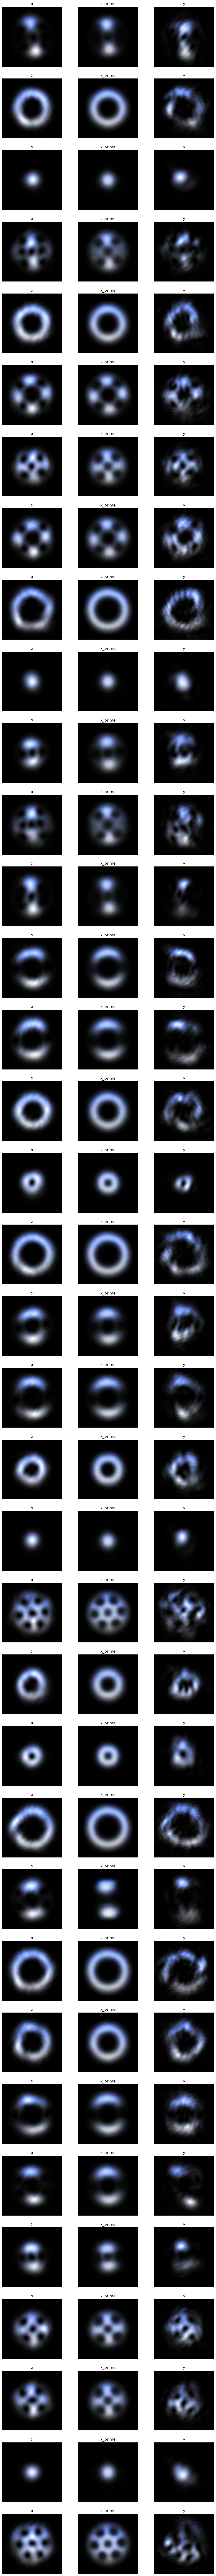

In [20]:
fig, ax = plt.subplots(nrows=bs, ncols=3, figsize=(12,4*bs))

a.train(False)
a.load_state_dict(torch.load(out_path))

x, y = next(iter(train_dataloader))
x = x.to(device)
y = y.to(device)
out = a(y)

for i in range(bs):
    
    ax[i][0].imshow(x[i].permute(1,2,0).cpu().detach().numpy())
    ax[i][1].imshow(out[i].permute(1,2,0).cpu().detach().numpy())
    ax[i][2].imshow(y[i].permute(1,2,0).cpu().detach().numpy())
    
    ax[i][0].set_title('x')
    ax[i][1].set_title('x_prime')
    ax[i][2].set_title('y')
    
    ax[i][0].axis('off')
    ax[i][1].axis('off')
    ax[i][2].axis('off')

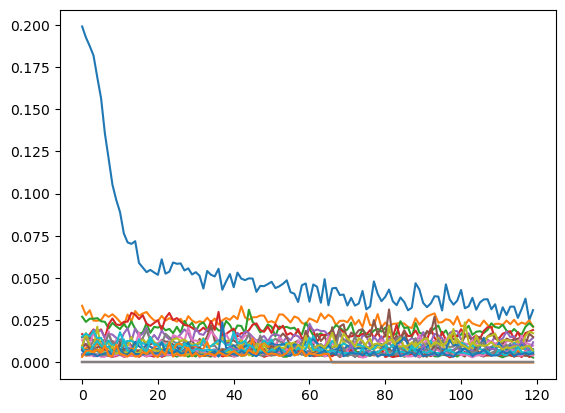

In [22]:
for i in range(n_epoch):
    plt.plot(logger.loss_matrix[i])